# Fourier Analysis Example
### Produces Figure 4

This notebook produces the figure for the example in the section Fourier Analysis. Here we look at the periodogram of hippocampal LFP data and see that the theta rhyth (8 Hz) dominates the signal.

### Import Libraries

In [9]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
from scipy import signal
from scipy import io

### Load data

In [10]:
x = io.loadmat('JBCA1ppDG_1-240615-SOR-open_field_egf2_ex.mat')
x = x['egf']
x = x.reshape(x.shape[0])
Fs = 4800

### Downsample
Here we downsample by the given $\textit{factor}$. 

In [11]:
factor = 4
Fs = Fs/factor
x = signal.decimate(x, q=factor, zero_phase=True)

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:3424: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


### Convert signal to millivolts

In [12]:
adc_conv = 1500/1000                      # ADC_fullscale_mv 1500
gain = 2000                               # gain_ch_28 2000
max_int_val = 2**(2*8-1)                  # 2 byte integers
R = 10000                                 # 10kOhm attenuator (in 0_Protocol - CA1ppDG Extinction Study.rtf)
attenuation = (R + 2000) / 2000           # annenuation factor

factor = attenuation/max_int_val*adc_conv/gain;  # from mTintCore read_eeg_file.m
x = x*factor                                     # converts to volt
x = 1000*1000*x                                  # converts to microvolt

### Periodogram

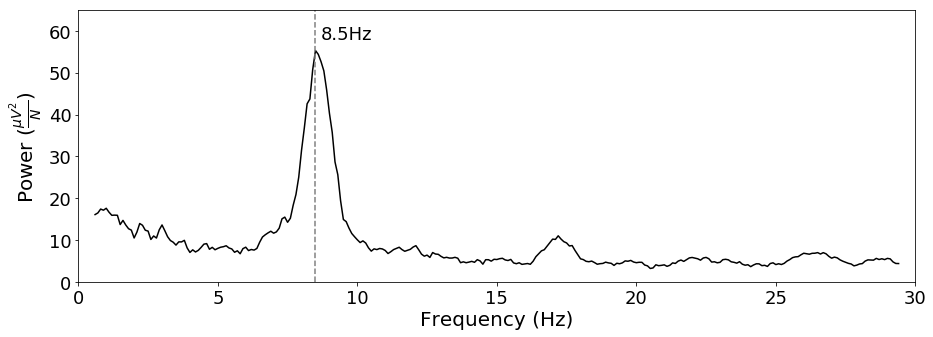

In [13]:
s1 = 0           # defines start of frequency window
s2 = 30          # defines end of frequency window
t1 = 0           # defines start of time window on which to compute fft
t2 = 10          # defines end of time window on which to compute fft

sig = x[int(t1*Fs):int(t2*Fs)]
nfft = len(sig)    # n-point discrete Fourier Transform, default is length of signal

# compute fft and get frequencies
x_hat = np.fft.fft(sig, nfft)
timestep = 1/Fs
freq = np.fft.fftfreq(nfft, d=timestep)
       
# select only freq interval [s1, s2] to display power spectrum
f_sel = freq[(s1<freq)&(freq<s2)]

# compute periodogram (absolute value of fourier transform divided by number of points)
periodogram = (1/nfft) * np.abs(x_hat[(s1<freq)&(freq<s2)])
log_periodogram = np.log10(periodogram)

# smooth the periodogram
n_freqs = len(f_sel)                             # number of frequency bins
n_pts = 5                                        # window, two-sided  
periodogram_smooth = np.zeros(n_freqs - 2*n_pts) # length is 2*n_pts shorter than periodogram
for t_i in range(n_pts, n_freqs-n_pts):
    periodogram_smooth[t_i-n_pts] = np.mean(periodogram[(t_i-n_pts) : (t_i+n_pts)])

# strongest frequency
max_f = f_sel[n_pts + np.argmax(periodogram_smooth)]

# plot    
plt.figure(figsize=(15,5))
plt.plot(f_sel[n_pts:(n_freqs-n_pts)], periodogram_smooth, color='black')
plt.axvline(max_f, 0, 16, linestyle='dashed', color='grey')
plt.text(max_f+0.2, 58, str(max_f) + 'Hz', fontsize=18)
plt.xlim(s1, s2)
plt.xticks(fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylim(0, 65)
plt.yticks(fontsize=18)
plt.ylabel('Power ' + r'($\frac{\mu V^2}{N}$)', fontsize=20)

plt.savefig('plots/ex_fourier_power_spectrum.pdf', bbox_inches = "tight")
plt.show()